In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import csv



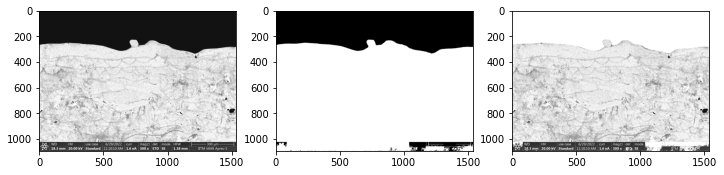

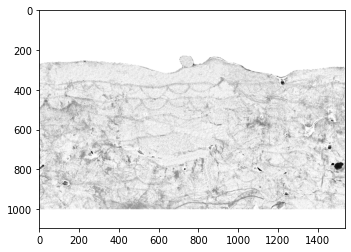

In [12]:
# img = cv2.imread(r"Data\Jag images\SST SIDE VIEW (SEM)\A\A2 retouch.tif")
img = cv2.imread(r"SEM\SEMImages\SIDE_VIEW_(SEM)\A\A2_retouch.tif")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

contours, hier = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
area=0
largest_contour = []
sorted_ = sorted(contours,key=cv2.contourArea,reverse=True)
biggest = sorted_[0]
for cnt in contours:
    if area<cv2.contourArea(cnt):
        area = cv2.contourArea(cnt)
        largest_contour = cnt

contours = np.array( [ [50,50], [50,150], [150, 150], [150,50] ] )
img2 = np.zeros( (1094,1536) ) # create a single channel 200x200 pixel black image 
cv2.fillPoly(img2, pts =[biggest], color=(255,255,255))
# img2 = cv2.bitwise_not(img2)
# bitwiseAnd = cv2.bitwise_and(img2, img)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(gray, cmap='gray')

plt.subplot(132)
plt.imshow(img2, cmap='gray')

img[img2 == 0] = 255
plt.subplot(133)
plt.imshow(img, cmap='gray')

plt.figure()
cv2.fillPoly(img, pts =np.array([[[0,1000],[1535,1000],[1535,1093],[0, 1093]]]), color=(255,255,255))
plt.imshow(img)


number of contours = 21
Number of circles = 4


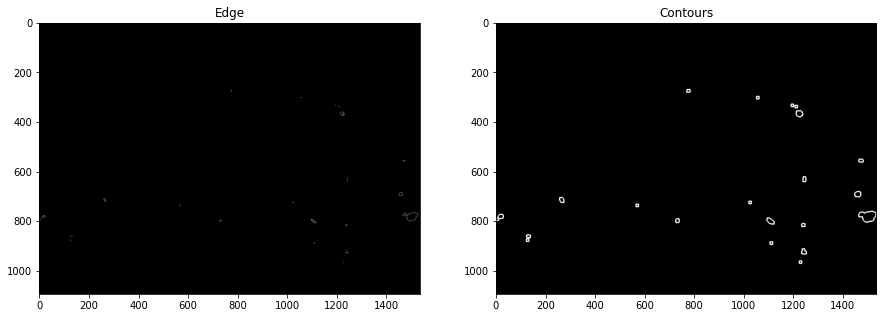

In [13]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.GaussianBlur(img, (3,3), 0)

## Simple Thresholding
ret,thresh = cv2.threshold(img,70,255,cv2.THRESH_BINARY)
 
# Canny Edge Detection
edges = cv2.Canny(image=thresh, threshold1=100, threshold2=200) # Canny Edge Detection

# Image dilation
img_dilation = cv2.dilate(edges, None, iterations=4)

# Finding total Contour in image
# contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("number of contours = " + str(len(contours)))
largest_contour = 0

contour_img = np.zeros(np.shape(img))

for i in range(len(contours)):
   cv2.drawContours(contour_img,contours,i,(255,0,0),3)
   if np.shape(contours[i])[0]>largest_contour:
      largest_contour = np.shape(contours[i])[0]
      largest_contr_idx = i

# Find circles
import numpy as np
output = img.copy()
output = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
op = np.zeros(np.shape(img))
circles = cv2.HoughCircles(img_dilation, cv2.HOUGH_GRADIENT, 1.3, 100)
# If some circle is found
if circles is not None:
   # Get the (x, y, r) as integers
   circles = np.round(circles[0, :]).astype("int")
   print(circles)
   # loop over the circles
   for (x, y, r) in circles:
      cv2.circle(output, (x, y), r, (0, 255, 0), 2)
# show the output image

contour_list = []
count = 0
for contour in contours:
   approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
   area = cv2.contourArea(contour)
   if ((len(approx) > 10) & (area > 0)): #& cv2.isContourConvex(approx)
      count+=1
      contour_list.append(contour)

cv2.drawContours(op, contour_list,  -1, (255,0,0), 2)

print("Number of circles = " + str(count))

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(edges, cmap='gray')
plt.title('Edge')
plt.subplot(122)
plt.imshow(contour_img, cmap='gray')
plt.title('Contours')
plt.show()

In [14]:
defects = []
std_thresh = 18
area_thresh = 300
img_area = np.shape(contour_img)[0] * np.shape(contour_img)[1]

import math
def dist(m,a):
    return math.sqrt((abs(m[0]-a[0])**2) + (abs(m[1]-a[1]**2)))

Defect count = 6
Lack of Fusion: color = Red, count = 0, area percentage = 0.000000 %
Blowhole: color = Green, count = 6, area percentage = 0.256281 %


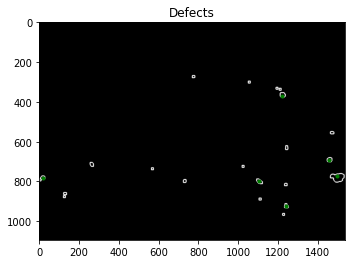

In [15]:
median = []
mean_d = []
std_d = []
contour_thresh = []
bh_count=0
lof_count=0
bh_area_percent=0
lof_area_percent=0


for contour in contours:
   approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
   area = cv2.contourArea(contour)
   if (area > area_thresh): #& cv2.isContourConvex(approx)
        m = ((np.sum(contour, axis=0))/len(contour)).squeeze()
        median.append(m)
        contour_thresh.append(contour)
        cnt = contour.squeeze()
        d = []
        for a in cnt:
            d.append(dist(m, a))
        mean_d.append(np.mean(d))
        std_d.append(np.std(d))
        
        area_percent = (area / img_area) * 100

        isCircle = np.std(d) < std_thresh
        if isCircle:
            bh_count+=1
            bh_area_percent+=area_percent
        else:
            lof_count+=1
            lof_area_percent+=area_percent

        defects.append({
            'contour':contour,
            'median':m,
            'area':area,
            'area_percent':area_percent,
            'mean':np.mean(d),
            'std':np.std(d),
            'isBlowhole':isCircle
        })


plt.imshow(contour_img, cmap='gray')
for a in defects:
    if a['isBlowhole']:
        color='green'
        plt.plot(a['median'][0], a['median'][1], '.', color=color, label='Blowhole')
    else:
        color = 'red'
        plt.plot(a['median'][0], a['median'][1], '.', color=color, label='Lack of Fusion')
    # plt.plot(a['median'][0], a['median'][1], '.', color=color)
# plt.legend()
plt.title('Defects')
print("Defect count = " + str(lof_count+bh_count))

print("Lack of Fusion: color = Red, count = {0}, area percentage = {1:1f} %".format(lof_count, lof_area_percent))

print("Blowhole: color = Green, count = {0}, area percentage = {1:1f} %".format(bh_count, bh_area_percent))

### Processing all images

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import csv
import os

In [47]:
std_thresh = 18
area_thresh = 300

def dist(m,a):
    return math.sqrt((abs(m[0]-a[0])**2) + (abs(m[1]-a[1]**2)))

In [48]:
def process(img, show = False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    contours, hier = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sorted_ = sorted(contours,key=cv2.contourArea,reverse=True)
    biggest = sorted_[0]

    img2 = np.zeros( (1094,1536) ) # create a single channel 200x200 pixel black image 
    cv2.fillPoly(img2, pts =[biggest], color=(255,255,255))
    img[img2 == 0] = 255
    cv2.fillPoly(img, pts =np.array([[[0,1000],[1535,1000],[1535,1093],[0, 1093]]]), color=(255,255,255))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (3,3), 0)
    ret,thresh = cv2.threshold(img,70,255,cv2.THRESH_BINARY)
    edges = cv2.Canny(image=thresh, threshold1=100, threshold2=200) # Canny Edge Detection
    img_dilation = cv2.dilate(edges, None, iterations=4)

    contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros(np.shape(img))

    for i in range(len(contours)):
        cv2.drawContours(contour_img,contours,i,(255,0,0),3)

    defects = []
    img_area = np.shape(img_dilation)[0] * np.shape(img_dilation)[1]
    median = []
    mean_d = []
    std_d = []
    contour_thresh = []
    bh_count=0
    lof_count=0
    bh_area_percent=0
    lof_area_percent=0


    for contour in contours:
        area = cv2.contourArea(contour)
        if (area > area_thresh): 
            m = ((np.sum(contour, axis=0))/len(contour)).squeeze()
            median.append(m)
            contour_thresh.append(contour)
            cnt = contour.squeeze()
            d = []
            for a in cnt:
                d.append(dist(m, a))
            mean_d.append(np.mean(d))
            std_d.append(np.std(d))
            
            area_percent = (area / img_area) * 100

            isCircle = np.std(d) < std_thresh
            if isCircle:
                bh_count+=1
                bh_area_percent+=area_percent
            else:
                lof_count+=1
                lof_area_percent+=area_percent

            defects.append({
                'contour':contour,
                'median':m,
                'area':area,
                'area_percent':area_percent,
                'mean':np.mean(d),
                'std':np.std(d),
                'isBlowhole':isCircle
            })

    if show:
        plt.imshow(contour_img, cmap='gray')
        for a in defects:
            if a['isBlowhole']:
                color='green'
                plt.plot(a['median'][0], a['median'][1], '.', color=color, label='Blowhole')
            else:
                color = 'red'
                plt.plot(a['median'][0], a['median'][1], '.', color=color, label='Lack of Fusion')
            # plt.plot(a['median'][0], a['median'][1], '.', color=color)
        # plt.legend()
        plt.title('Defects')

    def_count = lof_count+bh_count
    area_percent = lof_area_percent + bh_area_percent
    defect_stats = {
        "def_count" : def_count,
        "area_percent" : area_percent,
    }

    return defect_stats

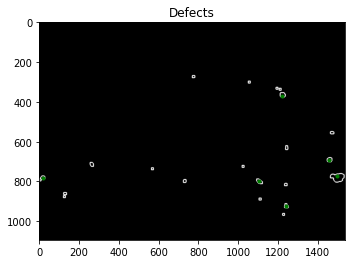

In [49]:
img = cv2.imread(r"C:\Users\Abhishek\Desktop\Am\Additive-Manufacturing-Defects\SEM\SEMImages\SIDE_VIEW_(SEM)\A\A2_retouch.tif")
defect_stats = process(img, show = True)

In [50]:
defect_stats['def_count']

6

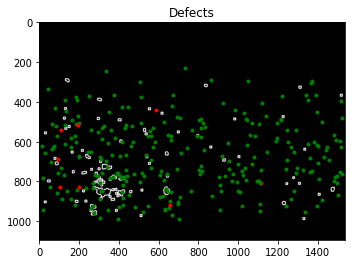

In [60]:
path = r"SEM\newdata"
def process_all_images(path):
    conditions = os.listdir(path)
    stats = {}
    for condition in conditions:
        stats[condition] = {}
        condition_path = path + "\\" + condition
        images = os.listdir(condition_path)
        n = len(images)
        # stats[condition]['n'] = n
        for img_name in images:
            if "tif" in img_name or "jpg" in img_name:
                img = cv2.imread(condition_path+"\\"+img_name)
                stats[condition][img_name] =process(img, show=True)
    return stats
stats = process_all_images(path)

In [2]:
def sum_stats(stats):
    stats_sum = []
    for condition in stats:
        condition_sum = {
            "condition" : condition,
            "def_count" : 0,
            "area_percent" : 0,
            "Number of images": 0
        }
        # condition_sum['Number of images'] = stats[condition]['n']
        for stat in stats[condition]:
            for param in stats[condition][stat]:
                condition_sum[param] += stats[condition][stat][param]

        condition_sum["area_percent"] = condition_sum["area_percent"]/len(stats[condition])
        stats_sum.append(condition_sum)
    return stats_sum

In [ ]:
complete_stats = sum_stats(stats)

In [54]:
def write_to_csv(list_of_dicts):
    with open("Out/SEMoutput.csv", 'w') as f:
        field_names = list(list_of_dicts[0].keys())
        writer = csv.DictWriter(f, fieldnames=field_names)
        writer.writeheader()
        for dictionary in list_of_dicts:
            writer.writerow(dictionary)
            

In [56]:
write_to_csv(complete_stats)

In [ ]:
if '__name__' == '__main__':
    path = r"SEM\SEMImages\S1\SIDE_VIEW_(SEM)\D"
    stats = process_all_images(path)
    complete_stats = sum_stats(stats)
    write_to_csv(complete_stats)